In [1]:
import sys
sys.path.append('../code/')

In [2]:
%load_ext autoreload
%autoreload 2

from libs import io
from libs import constants
from libs import vis

# Setup

In [3]:
SUMMARY_PATH = '../results/summaries'
VALID_RESPONSES_PATH = '../results/valid_responses'
PLOTS_PATH = '../results/plots'

FIGSIZE = (5,5)
FIGSIZE_WIDE = (12,5)
BAR_WIDTH = 0.7

FIGSPIDER = (5,7)
YLIM = (-0.05,3.05)

In [4]:
vis.sns_reset()
vis.sns_paper_style()

## Data

In [5]:
# Load the summary data for each model
df_summary = io.pd.concat([io.read_csv(io.path_join(SUMMARY_PATH, f"experiments_{model}.csv")) for model in constants.LLMS], ignore_index=True)
df_summary.head(1)

,llm_model,date,time,task_name,task_param,task_attempt,llm_completion_tokens,llm_prompt_tokens,llm_total_tokens,result_is_valid,result_valid_flag,result_original_message,file_path,model,valid_attempt
0,llama3-8b-8192,2024-12-09,00:00,epoch,1950s,1,488.0,600.0,1088.0,True,valid,Validation successful,../data/experiments/config_llama3-8b/run_20241...,llama3-8b,True


#  Validity of responses
Out of the three maximum attempts, was there at least one valid answer?

In [6]:
group_columns = ['model', 'result_valid_flag']
df_normalized = df_summary[group_columns].groupby(group_columns, dropna=False).size().reset_index(name='counts')
df_normalized['normalized_counts'] = df_normalized['counts'] / df_normalized.groupby(group_columns[:-1], dropna=False)['counts'].transform('sum')
df_normalized.head(2)

,model,result_valid_flag,counts,normalized_counts
0,gemma2-9b,invalid,3069,0.916667
1,gemma2-9b,valid,279,0.083333


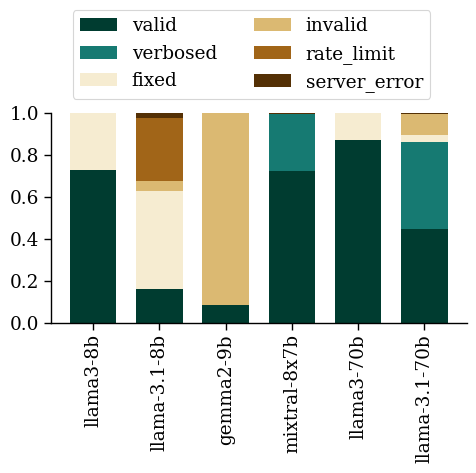

In [7]:
from matplotlib.pyplot import xlabel


fn = io.path_join(PLOTS_PATH, 'validity_of_responses.pdf')
vis.plot_barplot(df_normalized, x_col='model', y_col='normalized_counts', 
                     group_col='result_valid_flag', 
                     x_order = constants.LLMS,
                     group_order = constants.EXPERIMENT_OUTPUT_VALIDATION_FLAGS,
                     colors = constants.EXPERIMENT_OUTPUT_VALIDATION_FLAGS_COLORS,
                     xlabel_rotation=90, 
                     bar_width=BAR_WIDTH,
                     xlabel='', ylabel='',
                     legend_kwargs = {'title':'', 'loc': 'lower left', 'ncols':2, 'bbox_to_anchor':(0.03,1.02,1,0.2)}, #, , 'bbox_to_anchor':(1., 1)}, #loc='upper right', bbox_to_anchor=(1.5, 1)
                     figsize=(5,5),
                     fn=fn)

# Average number of attempts
Out of the three maximun attempts, how many on average were required until achieving a valid answer?

*Note: A valid answer is such that is been label as `valid` or `verbosed`. (to include ``fixed`` change ``EXPERIMENT_OUTPUT_VALID_FLAGS`` in ``libs/constants.py`` and run `batch_valid_answers.py` again)*

In [ ]:
# all valid attempts
df_valid_attempts = df_summary.query("valid_attempt == True").groupby(['model','task_name','task_param','date','time']).size().reset_index(name='valid_attempts').sort_values('valid_attempts', ascending=False)
df_valid_attempts = df_valid_attempts.merge(df_summary.query("valid_attempt == True")[['model','task_name','task_param','date','time','task_attempt']], on=['model','task_name','task_param','date','time'], how='left')

# cases where all 3 attempts are invalid
df_failed_attempts = df_summary.query("valid_attempt == False").groupby(['model','task_name','task_param','date','time']).size().reset_index(name='failed_attempts').sort_values('failed_attempts', ascending=False).query("failed_attempts==3")
df_failed_attempts.loc[:,'task_attempt'] = 3

# merge the two dataframes
df_all_answers = io.pd.concat([df_valid_attempts, df_failed_attempts], ignore_index=True)

# determining the number of failed attempts: succeeded at the first try
i = df_all_answers.query("valid_attempts == 1 and task_attempt == 1").index
df_all_answers.loc[i,'failed_attempts'] = 0

# determining the number of failed attempts: succeeded at the second try
i = df_all_answers.query("valid_attempts == 1 and task_attempt == 2").index
df_all_answers.loc[i,'failed_attempts'] = 1

# determining the number of failed attempts: succeeded at the 3rd try
i = df_all_answers.query("valid_attempts == 1 and task_attempt == 3").index
df_all_answers.loc[i,'failed_attempts'] = 2

# determining the number of failed attempts: succeeded at the 3rd try
i = df_all_answers.query("@io.pd.isnull(valid_attempts) and task_attempt == 3").index
df_all_answers.loc[i,'failed_attempts'] = 3
df_all_answers.loc[i,'valid_attempts'] = 0

df_all_answers.valid_attempts = df_all_answers.valid_attempts.astype(int)
df_all_answers.failed_attempts = df_all_answers.failed_attempts.astype(int)

df_all_answers.head(2)


,model,task_name,task_param,date,time,valid_attempts,task_attempt,failed_attempts
0,mixtral-8x7b,twins,random_male,2025-01-08,16:00,1,1,0
1,gemma2-9b,epoch,1950s,2024-12-09,00:00,1,1,0


## Overall per model

In [9]:
df_summary_fails_model = df_all_answers.groupby('model').failed_attempts.agg(['mean','std']).reset_index()
df_summary_fails_model

,model,mean,std
0,gemma2-9b,2.250000,1.299621
1,llama-3.1-70b,0.282962,0.713471
2,llama-3.1-8b,1.908602,1.437483
3,llama3-70b,0.144564,0.630475
4,llama3-8b,0.337515,0.944454
5,mixtral-8x7b,0.010155,0.170838


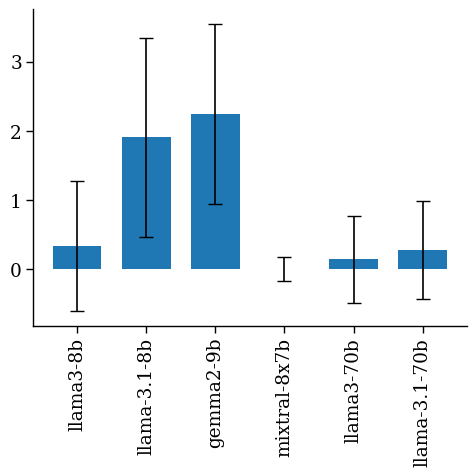

In [10]:
fn = io.path_join(PLOTS_PATH, 'mean_failed_attempts_per_model.pdf')
vis.plot_barplot(df_summary_fails_model, x_col='model', y_col='mean', err_col='std',
                     x_order = constants.LLMS,
                     xlabel_rotation=90, 
                     xlabel='', ylabel='',
                    bar_width=BAR_WIDTH,
                     figsize=FIGSIZE,
                     fn=fn)

## Per model and task

In [11]:
df_summary_fails_tasks = df_all_answers.groupby(['model','task_name']).failed_attempts.agg(['mean','std']).reset_index()
df_summary_fails_tasks.head(2)

,model,task_name,mean,std
0,gemma2-9b,epoch,1.5,1.504049
1,gemma2-9b,field,1.5,1.504049


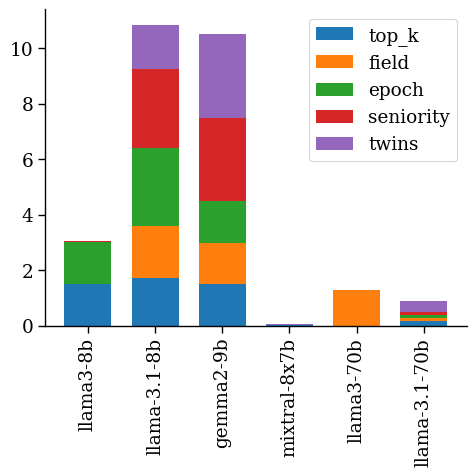

In [12]:
fn = io.path_join(PLOTS_PATH, 'mean_failed_attempts_per_task_and_model.pdf')
vis.plot_barplot(df_summary_fails_tasks, x_col='model', y_col='mean', 
                     group_col='task_name', 
                     x_order = constants.LLMS,
                     group_order = constants.EXPERIMENT_TASKS,
                     colors = constants.EXPERIMENT_TASKS_COLORS,
                     xlabel_rotation=90, 
                     bar_width=BAR_WIDTH,
                     xlabel='', ylabel='',
                     legend_kwargs = {'title':'', 'loc': 'best', 'ncols':1},
                     figsize=FIGSIZE,
                     fn=fn)

## Combined

In [13]:
combined = df_summary_fails_model.copy()
combined.loc[:,'task_name'] = 'all'
combined = io.pd.concat([combined, df_summary_fails_tasks], ignore_index=True)
combined.head(2)

,model,mean,std,task_name
0,gemma2-9b,2.250000,1.299621,all
1,llama-3.1-70b,0.282962,0.713471,all


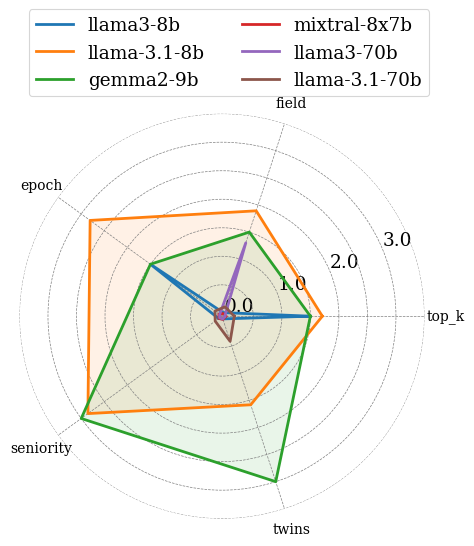

In [14]:
fn = io.path_join(PLOTS_PATH, 'mean_failed_attempts.pdf')

vis.plot_spiderweb(combined, x_col='task_name', x_order=constants.EXPERIMENT_TASKS, y_col='mean',
                   hue='model', hue_order=constants.LLMS, hue_colors=constants.LLMS_COLORS,
                   ylim=YLIM,ytickval=0.5, fn=fn,
                   legend_kwargs = {'title':'', 'loc': 'lower left', 'ncols':2, 'bbox_to_anchor':(0.0,1.02,1,0.2)},
                   figsize=FIGSPIDER)